# Encoder Transformers for Similary Search

The purpose of this notebook is to grasp a deeper understanding of the encoder transformers and how they can be used for similarity search. The notebook will cover the following topics:

1. What are encoder transformers?
2. How was BERT trained?
3. How did BERT become a sentence transformer? A look at siamese networks and triplet loss.

I will not cover contrastive loss in this notebook, but I have done a full implementation of it in another notebook.

References:

[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

[Mastering BERT Model: Building it from Scratch with Pytorch](https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891)

[Reimers, Nils, and Iryna Gurevych. “Sentence-BERT: Sentence Embeddings Using Siamese BERT-Networks.” arXiv, August 27, 2019.](http://arxiv.org/abs/1908.10084.)

[James Briggs: Sentence Similarity with Sentence-Transformers in Python](https://www.youtube.com/watch?v=Ey81KfQ3PQU&ab_channel=JamesBriggs])

[James Briggs: Fine-tune Sentence Transformers the OG Way (with NLI Softmax loss)](https://www.youtube.com/watch?v=aSx0jg9ZILo&t=1923s&ab_channel=JamesBriggs)



In [1]:
import random
import datasets
import itertools
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from tqdm import tqdm
from transformers import BertTokenizer, BertModel
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, GPT2Tokenizer, GPT2Model
from sentence_transformers import SentenceTransformer
from transformers.optimization import get_linear_schedule_with_warmup, AdamW
from sklearn.metrics.pairwise import cosine_similarity

/home/saul/.pyenv/versions/3.11.8/envs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. What are encoder transformers?

The transformer architecture was introduced in the paper [Attention is All You Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. The transformer architecture is a type of neural network that is based on the self-attention mechanism. The self-attention mechanism allows the model to weigh the importance of different words in a sentence when making predictions. The transformer architecture is composed of an encoder and a decoder. The encoder is used to encode the input sequence into a sequence of hidden states, and the decoder is used to decode the hidden states into the output sequence. The transformer architecture has been shown to be very effective for a wide range of natural language processing tasks, such as machine translation, text summarization, and language modeling.

The transformer architecture works extremely well due to the self-attention mechanism. The self-attention mechanism allows the model to weigh the importance of different words in a sentence when making predictions. The self-attention mechanism is a type of attention mechanism that is used to compute the attention weights between each pair of words in a sentence. The attention weights are then used to compute a weighted sum of the hidden states, which is used to make predictions. The self-attention mechanism is able to capture long-range dependencies between words in a sentence, which allows the model to make more accurate predictions.

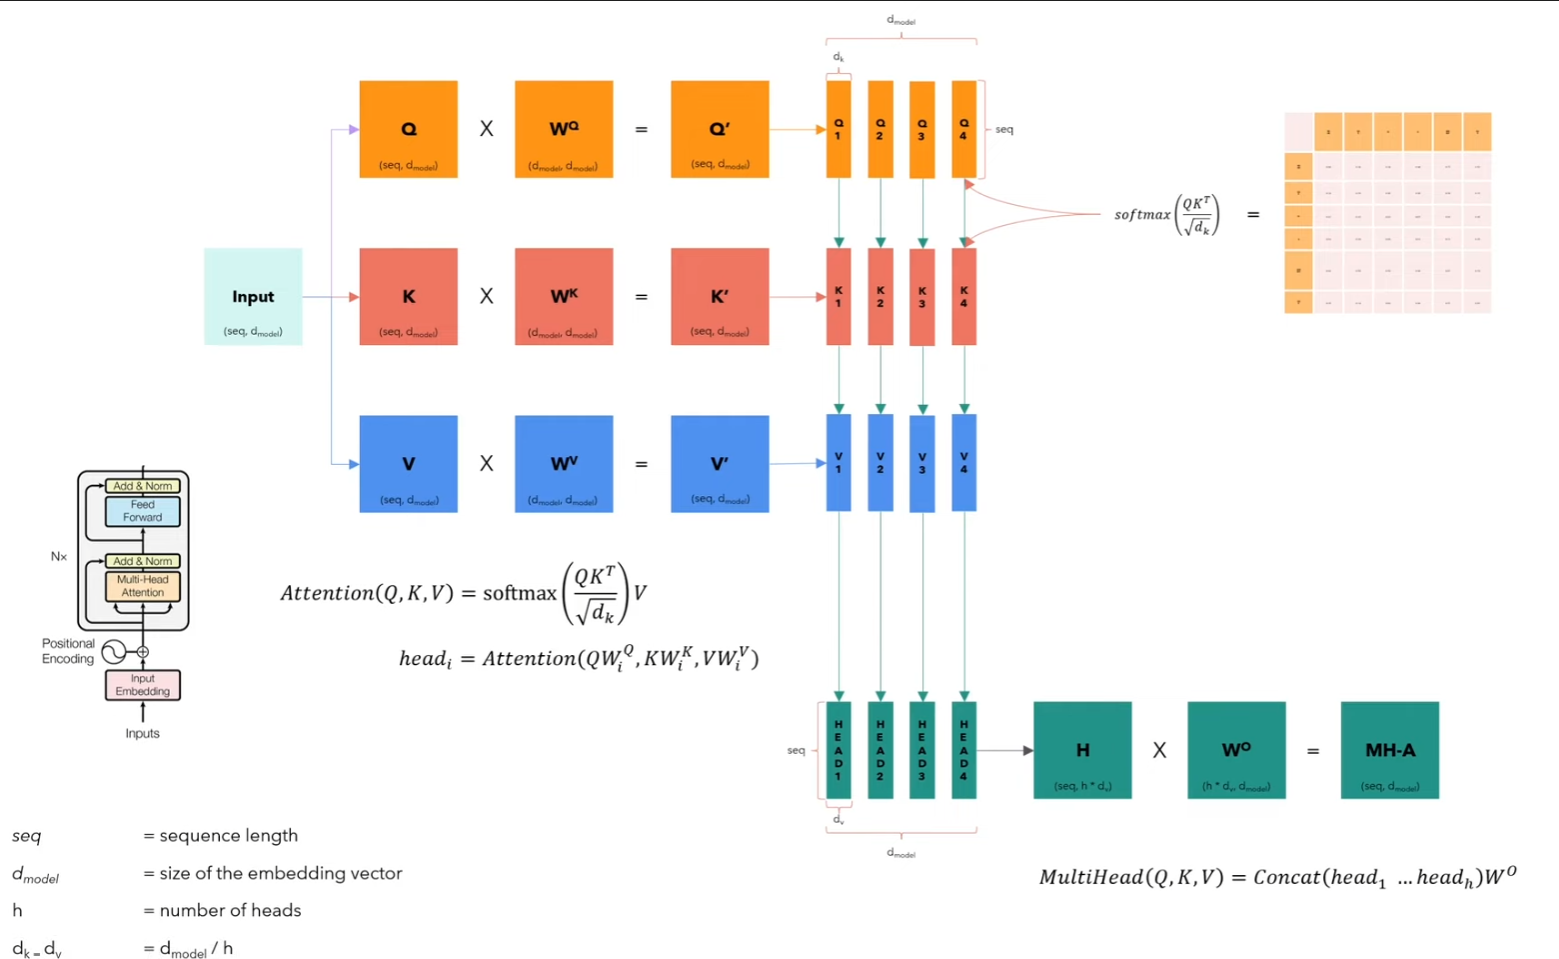

The first major encoder transformer model was the BERT model, which was introduced in the paper [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) by Devlin et al. The BERT model is a type of transformer model that is pre-trained on a large corpus of text data using a masked language modeling objective. The BERT model has been shown to achieve state-of-the-art performance on a wide range of natural language processing tasks, such as question answering, named entity recognition, and sentiment analysis.

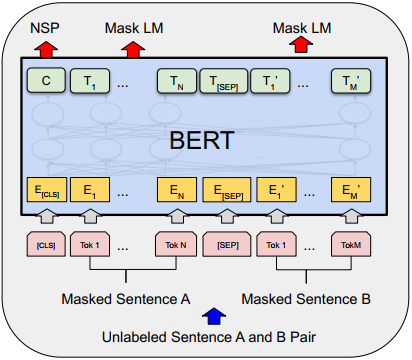

In [ ]:
class BERTEmbedding(nn.Module):
    """
    BERT Embedding module that combines token, positional, and segment embeddings.
    """

    def __init__(self, vocab_size: int, num_segments: int, max_sequence_length: int,
                 hidden_size: int, dropout: float = 0.1):
        """
        Initialize BERT Embedding module.

        Args:
            vocab_size (int): Size of the vocabulary.
            num_segments (int): Number of segments for segment embeddings.
            max_sequence_length (int): Maximum sequence length.
            hidden_size (int): Size of the hidden layer.
            dropout (float): Dropout rate (default: 0.1).
        """
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, hidden_size) # (30_000, 768) Uses Wordpiece Embedding
        self.positional_embedding = nn.Embedding(max_sequence_length, hidden_size) # (512, 768) Positional Embedding max_length is the context window size, model won't be able to see beyond this
        self.segment_embedding = nn.Embedding(num_segments, hidden_size) # (3, 768) Segment Embedding for distinguishing between sentences [CLS], [SEP], [PAD]
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("positional_input", torch.arange(max_sequence_length).unsqueeze(0))

    def forward(self, input_ids: torch.Tensor, segment_ids: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the BERT Embedding module.

        Args:
            input_ids (torch.Tensor): Input token IDs.
            segment_ids (torch.Tensor): Segment IDs for distinguishing different segments.

        Returns:
            torch.Tensor: Combined embeddings.
        """
        embeddings = (self.token_embedding(input_ids)
                      + self.positional_embedding(self.positional_input)
                      + self.segment_embedding(segment_ids))
        return self.dropout(embeddings)
    
class BERT(nn.Module):
    """
    BERT Transformer model for sequence classification.
    """

    def __init__(self, vocab_size: int, num_segments: int, max_sequence_length: int,
                 hidden_size: int, num_attention_heads: int, num_layers: int,
                 dropout: float = 0.1):
        """
        Initialize BERT Transformer model.

        Args:
            vocab_size (int): Size of the vocabulary.
            num_segments (int): Number of segments for segment embeddings.
            max_sequence_length (int): Maximum sequence length.
            hidden_size (int): Size of the hidden layer.
            num_attention_heads (int): Number of attention heads.
            num_layers (int): Number of transformer layers.
            dropout (float): Dropout rate (default: 0.1).
        """
        super().__init__()
        self.embedding = BERTEmbedding(vocab_size, num_segments, max_sequence_length,
                                       hidden_size, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_attention_heads,
                                                   dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, input_ids: torch.Tensor, segment_ids: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the BERT Transformer model.

        Args:
            input_ids (torch.Tensor): Input token IDs.
            segment_ids (torch.Tensor): Segment IDs for distinguishing different segments.

        Returns:
            torch.Tensor: Output logits.
        """
        x = self.embedding(input_ids, segment_ids)
        x = self.encoder(x)
        x = self.fc(x[:, 0])  # Assuming classification based on the [CLS] token
        return x

In [ ]:
# Example data (replace with your actual data)
# This is the tokenized input
# Shape: (batch_size, sequence_length) 
input_ids = torch.tensor([[1, 2, 3, 4, 0], [1, 2, 3, 0, 0]])  # Input token IDs

# This is the segment embedding
# This is used to distinguish between different segments (e.g. sentences)
# Shape: (batch_size, sequence_length) 
segment_ids = torch.tensor([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]])  # Segment IDs
labels = torch.tensor([1, 0])  # Example labels (binary classification)

# Hyperparameters
vocab_size = 30000
num_segments = 3
max_sequence_length = 5
hidden_size = 768
num_attention_heads = 12
num_layers = 6
dropout = 0.1
learning_rate = 1e-4
num_epochs = 10

# Instantiate model
model = BERT(vocab_size, num_segments, max_sequence_length, hidden_size,
                             num_attention_heads, num_layers, dropout)

# Shape: ((batch_size, sequence_length), (batch_size, sequence_length)) -> (batch_size, hidden_size)
model(input_ids, segment_ids)  # Forward pass

# 2. How was BERT trained?

BERT begins with WordPiece Tokenization, which is a subword tokenization algorithm that breaks words into smaller subwords. This allows the model to handle out-of-vocabulary words and reduces the size of the vocabulary. The BERT model is then trained using a masked language modeling objective, which involves masking 15% of the tokens in the input sequence and training the model to predict the masked tokens. The BERT model is also trained using a next sentence prediction objective, which involves training the model to predict whether two sentences are consecutive or not. The BERT model is trained on a large corpus of text data, such as Wikipedia and the BookCorpus, and is fine-tuned on a specific natural language processing task.

Example:
```
 “I like surfboarding!” → [‘[CLS]’, ‘i’, ‘like’, ‘surf’, ‘##board’, ‘##ing’, ‘!’, ‘[SEP]’] → [1, 48, 250, 4033, 3588, 154, 5, 2]
```

Pre-training is pretty unique to BERT. It's a two-step process that involves training the model on a large corpus of text and then fine-tuning the model on a specific task.

1) Masked Language Model (MLM) - The model is trained to predict a masked token in a sentence. This is done by masking 15% of the tokens in the input sequence and then training the model to predict the masked tokens.

2) Next Sentence Prediction (NSP) - The model is trained to predict whether two sentences are consecutive or not. This is done by training the model to predict whether the second sentence is the next sentence in the input sequence.

Point number two is what I believe inspired the sentence transformer. The BERT model was trained to predict whether two sentences are consecutive or not. This means that there is some implicit understanding of the relationship between two sentences. This is what the sentence transformer aims to capture.

Example:
```
sentence_pairs = [
    ["I like cats", "I like dogs"],
]
```

Tokenized sentence pairs:
```
[
    [101, 1045, 2066, 6687, 102, 1045, 2066, 9850, 102],
]
```
Equivalent to:
```
[
    [CLS], I, like, cats, [SEP], I, like, dogs, [SEP]
]
```
Segment embeddings:
What sentence does each token belong to?
```
[
    0, 0, 0, 0, 0, 1, 1, 1, 1
]
```

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, data_pair, tokenizer, seq_len=64):

        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.corpus_lines = len(data_pair)
        self.lines = data_pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):

        # Step 1: get random sentence pair, either negative or positive (saved as is_next_label)
        t1, t2, is_next_label = self.get_sent(item)

        # Step 2: replace random words in sentence with mask / random words
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # Step 3: Adding CLS and SEP tokens to the start and end of sentences
         # Adding PAD token for labels
        t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
        t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
        t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']] # label is 1/0 for each token
        t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

        # Step 4: combine sentence 1 and 2 as one input
        # adding PAD tokens to make the sentence same length as seq_len
        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]
        padding = [self.tokenizer.vocab['[PAD]'] for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = sentence.split()
        output_label = []
        output = []

        # 15% of the tokens would be replaced
        for i, token in enumerate(tokens):
            prob = random.random()

            # remove cls and sep token
            token_id = self.tokenizer(token)['input_ids'][1:-1]

            if prob < 0.15:
                prob /= 0.15

                # 80% chance change token to mask token
                if prob < 0.8:
                    for i in range(len(token_id)):
                        output.append(self.tokenizer.vocab['[MASK]'])

                # 10% chance change token to random token
                elif prob < 0.9:
                    for i in range(len(token_id)):
                        output.append(random.randrange(len(self.tokenizer.vocab)))

                # 10% chance change token to current token
                else:
                    output.append(token_id)

                output_label.append(token_id)

            else:
                output.append(token_id)
                for i in range(len(token_id)):
                    output_label.append(0)

        # flattening
        output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
        output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
        assert len(output) == len(output_label)
        return output, output_label

    def get_sent(self, index):
        '''return random sentence pair'''
        t1, t2 = self.get_corpus_line(index)

        # negative or positive pair, for next sentence prediction
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        '''return sentence pair'''
        return self.lines[item][0], self.lines[item][1]

    def get_random_line(self):
        '''return random single sentence'''
        return self.lines[random.randrange(len(self.lines))][1]

Sample output
```
{
'bert_input': tensor([    1, 13478,    17,   314,   276, 20966, 15344, 16603,  4456,  1903,
        13535,    48,   481,    11,    59,   719,   146,    17,     3,  1620,
           17,     2,   179,    48,    11,   265,   217,     3,  1570,  2244,
           17,     2,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 
            
'bert_label': tensor([    0,     0,     0,     0,     0,   185,    17,    17,    17, 13478,
           17,     0,     0,     0,     0,     0,     0,     0,    48,     0,
            0,     0,     0,     0,     0,     0,     0,   150,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 
            
'segment_label': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 
        
'is_next': tensor(0)
}
```

The way that BERT is trained is that we calculate the loss of the masked language model and the next sentence prediction. The loss is then backpropagated through the network and the weights are updated. This is done for a large number of iterations until the model converges.

In [ ]:
class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))


class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, 2)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))


class BERTLM(torch.nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)

In [ ]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [ ]:
class BERTTrainer:
    def __init__(
        self, 
        model, 
        train_dataloader, 
        test_dataloader=None, 
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=10,
        device='cuda'
        ):

        self.device = device
        self.model = model
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
    
    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):
        
        avg_loss = 0.0
        total_correct = 0
        total_element = 0
        
        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        ) 

# 3. How did BERT become a sentence transformer? A look at siamese networks and twin/triplet loss.

Be aware that softmax loss is no longer the preferred approach to training sentence transformers and has been superseded by other methods such as MSE margin and multiple negatives ranking loss. But we're covering this training method as an important milestone in the development of ever-improving sentence embeddings.

Model architecture:

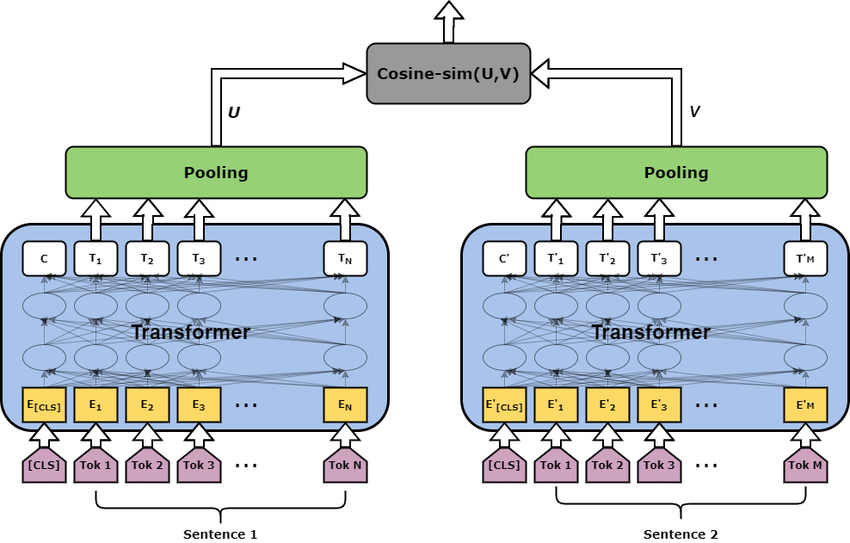

## Dataset Preparation

We are using the Stanford Natural Language Inference (SNLI) dataset, which has the following labels:

SNLI is a widely used benchmark in natural language processing (NLP) and machine learning research. It was created by the Stanford NLP Group to evaluate models on the task of natural language inference, which involves determining the logical relationship between pairs of sentences.

The SNLI dataset consists of over half a million labeled pairs of sentences, collected from image captions on the Flickr website. Each pair of sentences is labeled with one of three classes indicating the relationship between them: "entailment," "contradiction," or "neutral." These labels represent whether the meaning of the first sentence logically entails, contradicts, or is neutral with respect to the meaning of the second sentence.

    0: entailment, the premise entails the hypothesis e.g. the sentences have the same meaning
    1: neutral, the premise and hypothesis are neutral e.g. the sentences could be true but have no relation
    2: contradiction, the premise contradicts the hypothesis e.g. the sentences have opposite meaning

In [ ]:
snli = datasets.load_dataset('snli', split='train')
snli[0:3]

We also look at the MultiNL (MNLI) dataset.

MNLI is another creation from the Stanford NLP Group, designed to further advance research in natural language processing (NLP) and machine learning. MNLI stands for Multi-Genre Natural Language Inference, and it serves as an extension and enhancement of the Stanford Natural Language Inference (SNLI) dataset.

In [ ]:
mnli = datasets.load_dataset('glue', 'mnli', split='train')
mnli = mnli.remove_columns(['idx'])
mnli

In [ ]:
# datsets need to be concatenated before they can be used. But need preprecessing first as they don't have the same columns
dataset = datasets.concatenate_datasets([snli, mnli]) # len = 942_854 samples

## Tokenize and Encode Sentences

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# Preprocess labels: There are -1 labels in the dataset, which need to be removed
# len = 942_069 samples
dataset = dataset.filter(
    lambda x: x['label'] != -1
) 

In [ ]:
# Preprocess text: Tokenize and truncate
all_cols = ["label"]

for sample in ['premise', 'hypothesis']:
    dataset = dataset.map(
        lambda x: tokenizer(
            x[sample], max_length=128, padding='max_length', truncation=True, 
            ),
        batched=True # batched=True is required for map to work on a dataset
    )

    # renames 'input_ids' and 'attention_mask' to 'premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask'
    for col in ['input_ids', 'attention_mask']:
        dataset = dataset.rename_column(
            col, f'{sample}_{col}'
        )
        all_cols.append(f'{sample}_{col}')

dataset.set_format(type='torch', columns=all_cols)
print(all_cols) # ['label', 'premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask']

In [ ]:
batch_size = 16
dataloader_train = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Build Model Setup

In [ ]:
# Shape: ((batch_size, sequence_length, hidden_size), (batch_size, sequence_length)) -> (batch_size, hidden_size)
# Example: ((16, 128, 768), (16, 128)) -> (16, 768)
def mean_pool(token_embeddings: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    """
    Perform mean pooling over token embeddings considering attention mask.

    Args:
        token_embeddings (torch.Tensor): Tensor of shape (batch_size, sequence_length, hidden_size)
            containing the token embeddings.
        attention_mask (torch.Tensor): Tensor of shape (batch_size, sequence_length) representing
            attention mask, where 1 indicates valid tokens and 0 indicates padding tokens.

    Returns:
        torch.Tensor: Mean-pooled representation of token embeddings, with shape (batch_size, hidden_size).
    """
    # Apply attention mask to exclude padding tokens
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    
    # Sum token embeddings while considering attention mask and take the mean
    pool = torch.sum(token_embeddings * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    
    return pool

In [ ]:
# Sample token embeddings and attention mask tensors
sample_batch_size = 2
sample_sequence_length = 5
sample_hidden_size = 768

sample_token_embeddings = torch.randn(sample_batch_size, sample_sequence_length, sample_hidden_size)
sample_attention_mask = torch.tensor([[1, 1, 1, 0, 0], [1, 1, 0, 0, 0]])  # Example attention mask

# Apply mean pooling
sample_pooled_representation = mean_pool(sample_token_embeddings, sample_attention_mask)

# Now you can use the pooled representation for further processing or analysis
print("Pooled representation shape:", sample_pooled_representation.shape)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # needs to be changed to mps for MacOs
model.to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 1

# setup warmup for first 10% of training steps
total_steps = int(len(dataset) / batch_size * epochs)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, warmup_steps, total_steps
    )

ffnn = nn.Linear(768*3, 3).to(device)
criterion = nn.CrossEntropyLoss().to(device)

## Train Model

In [ ]:
# 1 epoch should be enough, increase if wanted
for epoch in range(epochs):
    model.train()
    # initialize the dataloader loop with tqdm
    loop = tqdm(dataloader_train, leave=True)
    for batch in loop:
        # zero all gradients on each new step
        optimizer.zero_grad()
        # unpack batch from dataloader and send to device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        attention_mask_a = batch['premise_attention_mask'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_mask_b = batch['hypothesis_attention_mask'].to(device)
        labels = batch['label'].to(device)
        # extract token embeddings from BERT
        u = model(inputs_ids_a, attention_mask=attention_mask_a)[0] # (batch_size, seq_len, hidden_size) # [0] is the last_hidden_state
        v = model(inputs_ids_b, attention_mask=attention_mask_b)[0] # (batch_size, seq_len, hidden_size) # [0] is the last_hidden_state
        # pool the embeddings into single vector
        u = mean_pool(u, attention_mask_a) # (batch_size, hidden_size)
        v = mean_pool(v, attention_mask_b) # (batch_size, hidden_size)
        uv_abs = torch.abs(u-v) # (batch_size, hidden_size)
        # concatenate pooled embeddings
        x = torch.cat([u, v, uv_abs], dim=1) # (batch_size, hidden_size*n_outputs)
        # pass through feed-forward network
        logits = ffnn(x) # (batch_size, n_outputs) # 3 is the number of classes
        # calculate loss and update weights
        loss = criterion(logits, labels)
        # calculate gradients
        loss.backward()
        # clip gradients to help with training stability
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # update learning rate scheduler to be linearly decreasing
        scheduler.step()
        # update the tqdm loop with current loss
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

## Inference

In [ ]:
# Define input sentence
input_sentence = "Three years later, the coffin was still full of Jello."

# Define other sentences
sentences = [
    "The fish dreamed of escaping the fishbowl and into the toilet where he saw his friend go.",
    "The person box was packed with jelly many dozens of months later.",
    "Standing on one's head at job interviews forms a lasting impression.",
    "It took him a month to finish the meal.",
    "He found a leprechaun in his walnut shell."
]

In [ ]:
# Tokenize input sentence
input_ids_a = tokenizer(input_sentence, return_tensors='pt', padding=True, truncation=True)['input_ids'].to(device)
attention_mask_a = tokenizer(input_sentence, return_tensors='pt', padding=True, truncation=True)['attention_mask'].to(device)

# Forward pass through SBERT model to get embeddings
u = model(input_ids_a, attention_mask=attention_mask_a)[0]  # (1, seq_len, hidden_size)
u = mean_pool(u, attention_mask_a)  # (1, hidden_size)

# Compute embeddings for other sentences
embeddings = []
for sentence in sentences:
    input_ids_b = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)['input_ids'].to(device)
    attention_mask_b = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)['attention_mask'].to(device)
    v = model(input_ids_b, attention_mask=attention_mask_b)[0]  # (1, seq_len, hidden_size)
    v = mean_pool(v, attention_mask_b)  # (1, hidden_size)
    embeddings.append(v)

# Convert embeddings list to tensor
embeddings = torch.cat(embeddings, dim=0)  # (num_sentences, hidden_size)

In [ ]:
# Compute cosine similarity between input sentence and all other sentences
similarity_scores = cosine_similarity(u.cpu().detach().numpy(), embeddings.cpu().detach().numpy())  # (1, num_sentences)

# Find index of most similar sentence
most_similar_index = similarity_scores.argmax()

# Print most similar sentence
print("Input sentence:", input_sentence)
print("Similarity scores:", similarity_scores)
print("Most similar sentence:", sentences[most_similar_index])

# 4. Bonus - BERT as a sentence transformer with HuggingFace

In [ ]:
sentences = [
    "Three years later, the coffin was still full of Jello.",
    "The fish dreamed of escaping the fishbowl and into the toilet where he saw his friend go.",
    "The person box was packed with jelly many dozens of months later.",
    "Standing on one's head at job interviews forms a lasting impression.",
    "It took him a month to finish the meal.",
    "He found a leprechaun in his walnut shell."
]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

# initialize dictionary that will contain tokenized sentences
tokens = {'input_ids': [], 'attention_mask': []}

for sentence in sentences:
    # tokenize sentence and append to dictionary lists max_length=128 because it's a BERT destill
    # returns dictionary of lists of tensors
    # we need to pull input and attention mask from dictionary
    new_tokens = tokenizer.encode_plus(sentence, max_length=128, truncation=True,
                                       padding='max_length', return_tensors='pt')
    # append new tokens to dictionary
    tokens['input_ids'].append(new_tokens['input_ids'][0])
    # append new attention mask to dictionary
    tokens['attention_mask'].append(new_tokens['attention_mask'][0])

# reformat list of tensors into single tensor
# Shape: (batch_size, sequence_length)
tokens['input_ids'] = torch.stack(tokens['input_ids'])
print(tokens['input_ids'].shape)
# Shape: (batch_size, sequence_length)
tokens['attention_mask'] = torch.stack(tokens['attention_mask'])
print(tokens['attention_mask'].shape)

In [ ]:
# run tokens through model
outputs = model(**tokens)
outputs.keys()

# last_hidden_state is the last layer of the model
embeddings = outputs.last_hidden_state
embeddings

# remove padding tokens with attention mask
# need to add the 768 features per token
attention_mask = tokens['attention_mask']
print('attention mask size is: ', attention_mask.shape)
mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
print('mask size is: ', mask.shape)

In [ ]:
# apply mask to embeddings to only get non-padded tokens
masked_embeddings = embeddings * mask
print('masked embeddings size: ', masked_embeddings.shape)
print('we need to sum acros the 128 tokens to get a single vector for each sentence')
masked_embeddings

In [ ]:
# need to get mean pooling of non-padded tokens
summed = torch.sum(masked_embeddings, 1)
summed.shape

In [ ]:
# counts of features that are not padding (1 if not padding, 0 if padding)
counts = torch.clamp(mask.sum(1), min=1e-9)
counts.shape

In [ ]:
mean_pooled = summed / counts
mean_pooled.shape

In [ ]:
# convert from PyTorch tensor to numpy array
mean_pooled = mean_pooled.detach().numpy()

# calculate
cosine_similarity(
    [mean_pooled[0]],
    mean_pooled[1:]
)

These similarities translate to:

input
`"Three years later, the coffin was still full of Jello."`

| Index | Sentence | Similarity |
| --- | --- | --- |
| 1 | "The fish dreamed of escaping the fishbowl and into the toilet where he saw his friend go." | 0.3309 |
| 2 | "The person box was packed with jelly many dozens of months later." | 0.7219 |
| 3 | "Standing on one's head at job interviews forms a lasting impression." | 0.1748 |
| 4 | "It took him a month to finish the meal." | 0.4471 |
| 5 | "He found a leprechaun in his walnut shell." | 0.5548 |


So, as intended, the most similar sentence is that in index **2** - which contains the same meaning as our first sentence, without using the same words:

## Using the sentence-transformer

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
sentence_embeddings = model.encode(sentences)
sentence_embeddings

In [ ]:
cosine_similarity(
    [sentence_embeddings[0]],
    sentence_embeddings[1:]
)

# 5. Can we obtain embeddings with a causal language model like GPT-2?

In [2]:
# Load pre-trained GPT-2 model and tokenizer
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2Model.from_pretrained(model_name)

In [3]:
sentences_gpt = [
    "The fish dreamed of escaping the fishbowl and into the toilet where he saw his friend go.",
    "The person box was packed with jelly many dozens of months later.",
    "Standing on one's head at job interviews forms a lasting impression.",
    "It took him a month to finish the meal.",
    "He found a leprechaun in his walnut shell."
]

In [5]:
# Input text
input_text_gpt = "Three years later, the coffin was still full of Jello.",

# Tokenize input text
inputs = tokenizer(input_text_gpt, return_tensors="pt")

# Forward pass through the model
outputs = model(**inputs, output_hidden_states=True)

# Extract hidden states
hidden_states = outputs.hidden_states

# Access hidden states from the last layer
# Shape: (batch_size, sequence_length, hidden_size) -> (1, sequence_length, hidden_size) for this example
# (1, 3, 768) for this example
last_layer_hidden_states = hidden_states[-1]

# Apply mean pooling to get sentence embeddings
# Shape: (batch_size, sequence_length, hidden_size) -> (batch_size, hidden_size) -> (1, hidden_size) for this example
# (1, 768) for this example
mask = inputs['attention_mask'].unsqueeze(-1).expand(last_layer_hidden_states.size()).float()
masked_hidden_states = last_layer_hidden_states * mask
summed = torch.sum(masked_hidden_states, 1)
counts = torch.clamp(mask.sum(1), min=1e-9)
sentence_embedding_input = summed / counts

print("Input text:", input_text_gpt)
print("Number of Tokens:", inputs['input_ids'].shape[1])
print("Sentence Hidden States shape:", last_layer_hidden_states.shape)
print("Sentence embedding shape:", sentence_embedding_input.shape)

Input text: ('Three years later, the coffin was still full of Jello.',)
Number of Tokens: 13
Sentence Hidden States shape: torch.Size([1, 13, 768])
Sentence embedding shape: torch.Size([1, 768])


In [7]:
embeddings = []
for sentence in sentences_gpt:
    # Tokenize input sentence
    inputs = tokenizer(sentence, return_tensors="pt")
    # Forward pass through the model
    outputs = model(**inputs, output_hidden_states=True)
    # Extract hidden states
    hidden_states = outputs.hidden_states
    # Access hidden states from the last layer
    last_layer_hidden_states = hidden_states[-1]
    # Apply mean pooling to get sentence embeddings
    mask = inputs['attention_mask'].unsqueeze(-1).expand(last_layer_hidden_states.size()).float()
    masked_hidden_states = last_layer_hidden_states * mask
    summed = torch.sum(masked_hidden_states, 1)
    counts = torch.clamp(mask.sum(1), min=1e-9)
    sentence_embedding = summed / counts
    embeddings.append(sentence_embedding)

# Convert embeddings list to tensor
sentence_embeddings = torch.cat(embeddings, dim=0)
print(sentence_embeddings.shape)

torch.Size([5, 768])


In [8]:
# Compute cosine similarity between input sentence and all other sentences
similarity_scores = cosine_similarity(
    sentence_embedding_input.detach().numpy(),
    sentence_embeddings.detach().numpy(),
    )

similarity_scores

array([[0.99791324, 0.997968  , 0.99823284, 0.9974538 , 0.99588716]],
      dtype=float32)